In [1]:
from core import gen, eval
from decaGEN import grammar
import pandas as pd

model = 'WSWSWSWSWS'
o1980 = grammar(model, gen.oliva1980, eval.oliva1980, False).sort_values(by='Complexitat')
o1992 = grammar(model, gen.oliva1992, eval.oliva1992, False).sort_values(by='Complexitat')
j2019 = grammar('', gen.jimenez2019, eval.jimenez2019, False).sort_values(by='Complexitat')

def normalize_o1992(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    if 'Pattern' not in df.columns:
        raise ValueError("DataFrame must contain `Pattern` column")

    def _map_pattern(ex):
        s = str(ex)
        def map_ch(ch):
            if not ch.isdigit():
                return ch
            d = int(ch)
            if d < 2:
                return 'A'
            if d == 2:
                return 't'
            return 'T'
        return ''.join(map_ch(ch) for ch in s)

    df_copy = df.copy()
    df_copy['Pattern'] = df_copy['Pattern'].apply(_map_pattern)

    # select numeric columns to average (rule columns)
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

    if numeric_cols:
        grouped = df_copy.groupby('Pattern')[numeric_cols].mean().reset_index()
        grouped[numeric_cols] = grouped[numeric_cols].round(3)
    else:
        grouped = df_copy[['Pattern']].drop_duplicates().reset_index(drop=True)

    counts = df_copy.groupby('Pattern').size().reset_index(name='Count')
    result = grouped.merge(counts, on='Pattern')

    # keep Pattern as first column
    cols = ['Pattern'] + [c for c in result.columns if c != 'Pattern']
    return result[cols]

# Usage (in your notebook)
o1992 = normalize_o1992(o1992).sort_values(by='Complexitat')
o1992

,Pattern,RM1,RM2,RAB,RADB,RC1,RC2,RC3,Complexitat,Count
30,ATATATATAT,0.0,0.0,0.0,0.0,0.0,0.0,0.667,0.667,12
8,AAATATATAT,0.0,0.0,0.0,0.0,0.0,1.0,0.667,1.667,6
29,ATATATAAAT,0.0,0.0,0.0,0.0,0.0,1.0,0.667,1.667,6
31,ATATATAtAT,0.0,0.0,1.0,0.0,0.0,0.0,0.667,1.667,6
46,AtATATATAT,0.0,0.0,1.0,0.0,0.0,0.0,0.667,1.667,6
...,...,...,...,...,...,...,...,...,...,...
20,AAtAATATAT,1.0,2.0,1.0,0.0,1.0,2.0,1.000,8.000,2
21,AAtAATAtAT,1.0,2.0,2.0,0.0,1.0,2.0,1.000,9.000,1
19,AAtAATAAAT,1.0,2.0,1.0,0.0,1.0,3.0,1.000,9.000,1
69,TATAATAAAT,2.0,1.0,0.0,0.0,2.0,3.0,1.000,9.000,1


## Anàlisi de les gramàtiques generades

### Patrons generats

In [2]:
# Compta en un únic dataframe els patrons generats per cada gramàtica
grammars = {
    'o1980': o1980,
    'o1992': o1992,
    'j2019': j2019
}
counts = {}
for name, df in grammars.items():
    counts = {name: len(df) for name, df in grammars.items()}
    counts = pd.DataFrame.from_dict(counts, orient='index', columns=['Nombre de patrons'])
counts



,Nombre de patrons
o1980,40
o1992,72
j2019,512


In [3]:
# identifica els patrons comuns entre les gramàtiques (df)
def common_patterns(df1, df2):
    patterns1 = set(df1['Pattern'])
    patterns2 = set(df2['Pattern'])
    common = patterns1.intersection(patterns2)
    return common
common_o1980_o1992 = common_patterns(o1980, o1992)
common_o1980_j2019 = common_patterns(o1980, j2019)
common_o1992_j2019 = common_patterns(o1992, j2019)

print('Common patterns between Oliva 1980 and Oliva 1992:', len(common_o1980_o1992))
print('Common patterns between Oliva 1980 and Jimenez 2019:', len(common_o1980_j2019))
print('Common patterns between Oliva 1992 and Jimenez 2019:', len(common_o1992_j2019))

# identifica els patrons que són comuns a les tres gramàtiques
def common_patterns_three(df1, df2, df3):
    patterns1 = set(df1['Pattern'])
    patterns2 = set(df2['Pattern'])
    patterns3 = set(df3['Pattern'])
    common = patterns1.intersection(patterns2).intersection(patterns3)
    return common
common_all = common_patterns_three(o1980, o1992, j2019)
print('Common patterns between all three grammars:', len(common_all))

Common patterns between Oliva 1980 and Oliva 1992: 21
Common patterns between Oliva 1980 and Jimenez 2019: 40
Common patterns between Oliva 1992 and Jimenez 2019: 24
Common patterns between all three grammars: 21


In [4]:
# a partir de common_all genera un df amb els patrons comuns a les tres gramàtiques i el valor de complexitat de cada gramàtica per a cada patró
def common_patterns_df(df1, df2, df3, common_patterns):
    common_df = pd.DataFrame({'Pattern': list(common_patterns)})
    def get_complexity(row, df, col_name):
        if row['Pattern'] in df['Pattern'].values:
            return df.loc[df['Pattern'] == row['Pattern'], 'Complexitat'].values[0]
        return None
    common_df['o1980'] = common_df.apply(lambda row: get_complexity(row, df1, 'Complexitat'), axis=1)
    common_df['o1992'] = common_df.apply(lambda row: get_complexity(row, df2, 'Complexitat'), axis=1)
    common_df['j2019'] = common_df.apply(lambda row: get_complexity(row, df3, 'Complexitat'), axis=1)
    return common_df
common_patterns_dataframe = common_patterns_df(o1980, o1992, j2019, common_all)
# afegeix una columna de complexitat mitjana
common_patterns_dataframe['Mitjana'] = round(common_patterns_dataframe[['o1980', 'o1992', 'j2019']].mean(axis=1), 2)
# ordena per complexitat mitjana
common_patterns_dataframe = common_patterns_dataframe.sort_values(by='Mitjana')
common_patterns_dataframe = common_patterns_dataframe.reset_index(drop=True)
common_patterns_dataframe.index = common_patterns_dataframe.index + 1
common_patterns_dataframe.to_excel('common_patterns.xlsx', index=False)
common_patterns_dataframe

,Pattern,o1980,o1992,j2019,Mitjana
1,ATATATATAT,0,0.667,0,0.22
2,ATATATAAAT,1,1.667,1,1.22
3,AAATATATAT,1,1.667,1,1.22
4,ATATAAATAT,1,2.000,1,1.33
5,TAATATATAT,1,3.667,0,1.56
6,ATAAATATAT,1,3.000,1,1.67
7,AAATATAAAT,2,2.667,2,2.22
8,ATATAAAAAT,2,3.000,2,2.33
9,AAATAAATAT,2,3.000,2,2.33
10,ATATAATAAT,2,5.000,0,2.33


In [5]:
# Genera un únic dataframe amb tots els patrons. Elimina duplicats, però afegeix una columna que indica en quines gramàtiques apareix cada patró. Desa també el valor de complexitat de cada gramàtica per a cada patró: 'complexitat_o1980', 'complexitat_o1992', 'complexitat_j2019'
def merge_grammars(df1, df2, df3):
    all_patterns = pd.concat([df1, df2, df3]).drop_duplicates(subset=['Pattern']).reset_index(drop=True)
    all_patterns['In_Oliva1980'] = all_patterns['Pattern'].isin(df1['Pattern'])
    all_patterns['In_Oliva1992'] = all_patterns['Pattern'].isin(df2['Pattern'])
    all_patterns['In_Jimenez2019'] = all_patterns['Pattern'].isin(df3['Pattern'])

    def get_complexity(row, df, col_name):
        if row['Pattern'] in df['Pattern'].values:
            return df.loc[df['Pattern'] == row['Pattern'], 'Complexitat'].values[0]
        return None

    all_patterns['Complexitat_Oliva1980'] = all_patterns.apply(lambda row: get_complexity(row, df1, 'Complexitat'), axis=1)
    all_patterns['Complexitat_Oliva1992'] = all_patterns.apply(lambda row: get_complexity(row, df2, 'Complexitat'), axis=1)
    all_patterns['Complexitat_Jimenez2019'] = all_patterns.apply(lambda row: get_complexity(row, df3, 'Complexitat'), axis=1)

    return all_patterns
merged_grammars = merge_grammars(o1980, o1992, j2019)
merged_grammars.to_excel('merged_grammars.xlsx', index=False)

In [6]:
# Estadístiques bàsiques
def basic_statistics(df, name):
    total_patterns = len(df)
    avg_complexity = df['Complexitat'].mean()
    print(f'Statistics for {name}:')
    print(f'Total patterns: {total_patterns}')
    print(f'Average complexity: {avg_complexity:.2f}\n')
basic_statistics(o1980, 'Oliva 1980')
basic_statistics(o1992, 'Oliva 1992')
basic_statistics(j2019, 'Jimenez 2019')

Statistics for Oliva 1980:
Total patterns: 40
Average complexity: 2.20

Statistics for Oliva 1992:
Total patterns: 72
Average complexity: 4.49

Statistics for Jimenez 2019:
Total patterns: 512
Average complexity: 3.17



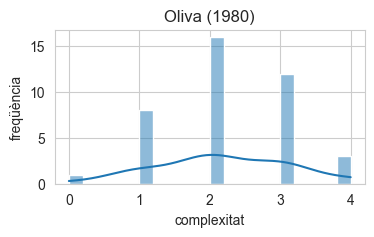

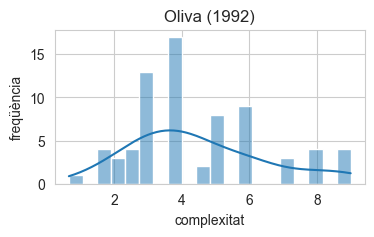

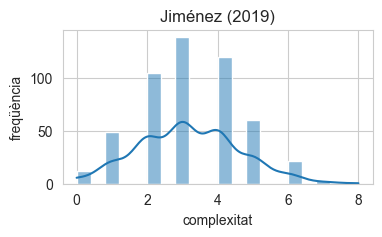

In [7]:
# plots de distribució de complexitat
import matplotlib.pyplot as plt
import seaborn as sns
def plot_complexity_distribution(df, name):
    plt.figure(figsize=(4, 2))
    sns.histplot(df['Complexitat'], bins=20, kde=True)
    plt.title(f'{name}')
    plt.xlabel('complexitat')
    plt.ylabel('freqüència')
    plt.show()
plot_complexity_distribution(o1980, 'Oliva (1980)')
plot_complexity_distribution(o1992, 'Oliva (1992)')
plot_complexity_distribution(j2019, 'Jiménez (2019)')

# Tots els patrons tots els avaluadors

In [8]:
all_o1980 = grammar(model, gen.jimenez2019, eval.oliva1980, False)
all_o1992 = grammar(model, gen.jimenez2019, eval.oliva1992b, False)
all_o1992.to_excel('all_o1992.xlsx', index=False)
all_o1980.to_excel('all_o1980.xlsx', index=False)


In [9]:
# mostra els valors de complexitat dels patrons 'ATATATATAT' i 'TTTTTTTTTT' per a cada avaluador
def get_pattern_complexity(df, pattern):
    if pattern in df['Pattern'].values:
        return df.loc[df['Pattern'] == pattern, 'Complexitat'].values[0]
    return None
patterns_to_check = ['ATATATATAT', 'TTTTTTTTTT']
df_results = {}
for pattern in patterns_to_check:
    complexity_o1980 = get_pattern_complexity(all_o1980, pattern)
    complexity_o1992 = get_pattern_complexity(all_o1992, pattern)
    complexity_j2019 = get_pattern_complexity(j2019, pattern)
    print(f'Pattern: {pattern}')
    results = {
        'o1980': complexity_o1980,
        'o1992': complexity_o1992,
        'j2019': complexity_j2019,
        'Mitjana': round(
            sum(filter(None, [complexity_o1980, complexity_o1992, complexity_j2019])) /
            len(list(filter(None, [complexity_o1980, complexity_o1992, complexity_j2019]))), 2) if any([complexity_o1980, complexity_o1992, complexity_j2019]) else None
    }
    print(results)
    df_results[pattern] = results
df_patterns_complexity = pd.DataFrame.from_dict(df_results, orient='index')
df_patterns_complexity


Pattern: ATATATATAT
{'o1980': np.int64(0), 'o1992': np.int64(0), 'j2019': np.int64(0), 'Mitjana': None}
Pattern: TTTTTTTTTT
{'o1980': np.int64(0), 'o1992': np.int64(5), 'j2019': np.int64(8), 'Mitjana': np.float64(6.5)}


,o1980,o1992,j2019,Mitjana
ATATATATAT,0,0,0,NaN
TTTTTTTTTT,0,5,8,6.5


In [10]:
# comprova si el patró 'TTTTTTTTTT' és el de major complexitat per a cada avaluador
def is_highest_complexity(df, pattern):
    if pattern not in df['Pattern'].values:
        return False
    pattern_complexity = df.loc[df['Pattern'] == pattern, 'Complexitat'].values[0]
    max_complexity = df['Complexitat'].max()
    return pattern_complexity == max_complexity
pattern_to_check = 'TTTTTTTTTT'
highest_o1980 = is_highest_complexity(all_o1980, pattern_to_check)
highest_o1992 = is_highest_complexity(all_o1992, pattern_to_check)
highest_j2019 = is_highest_complexity(j2019, pattern_to_check)
print(f'Is "{pattern_to_check}" the highest complexity pattern?')
print(f'Oliva 1980: {highest_o1980}')
print(f'Oliva 1992: {highest_o1992}')
print(f'Jimenez 2019: {highest_j2019}')

Is "TTTTTTTTTT" the highest complexity pattern?
Oliva 1980: False
Oliva 1992: False
Jimenez 2019: True


In [11]:
# mostra els 5 patrons amb major complexitat per a cada avaluador
def top_n_complexity(df, n=10):
    top_patterns = df.nlargest(n, 'Complexitat')
    return top_patterns[['Pattern', 'Complexitat']]
top_o1980 = top_n_complexity(all_o1980)
top_o1992 = top_n_complexity(all_o1992)
top_j2019 = top_n_complexity(j2019)
print('Top 5 patterns by complexity for Oliva 1980:')
print(top_o1980)
print('\nTop 5 patterns by complexity for Oliva 1992:')
print(top_o1992)
print('\nTop 5 patterns by complexity for Jimenez 2019:')
print(top_j2019)

Top 5 patterns by complexity for Oliva 1980:
        Pattern  Complexitat
481  AAAAAAAAAT            4
482  AAAATAAAAT            4
483  TAAATATATT            4
484  TATATATAAT            4
485  TAAATATAAT            4
486  AAAAAATAAT            4
487  AAAATAAATT            4
488  AAAATATATT            4
489  TAAATAAATT            4
490  AATAAAAAAT            4

Top 5 patterns by complexity for Oliva 1992:
        Pattern  Complexitat
512  TATATATATT           15
509  TATATAAATT           14
510  TATATATAAT           14
511  AATATATATT           14
503  AATATATAAT           13
504  TATATATTTT           13
505  TTTATATATT           13
506  TATAAATATT           13
507  TAAATATATT           13
508  AATATAAATT           13

Top 5 patterns by complexity for Jimenez 2019:
        Pattern  Complexitat
512  TTTTTTTTTT            8
508  ATTTTTTTTT            7
509  TTTTTTATTT            7
510  TTTATTTTTT            7
511  AAAATTTTTT            7
486  TTAATTTTTT            6
487  AAAAAATTTT     